In [46]:
from collections import defaultdict
import awkward as ak
import numba
import numpy as np
import pandas as pd
import h5py
import vector
vector.register_numba()
vector.register_awkward()

import matplotlib.pyplot as plt
#from matplotlib.colors import LogNorm
#import mplhep as hep
#hep.style.use(hep.style.ROOT)

## Plot the scores of the new trainings for the new cuts

In [47]:
# prefix="/afs/cern.ch/user/m/mmalucch/public/out_prediction_files/"
# filename_test_nc = prefix +"true_files/output_JetGood_test_allkl_new_kl_newcuts.h5"
# filename_pred_nc= prefix + "spanet_prediction_nc_on_nc_300e.h5"

# filename_test_nc="/afs/cern.ch/user/r/ramellar/HH4b_SPANet/spanet_prediction_5_jets.h5"
filename_true_nc="/eos/home-r/ramellar/2_spanet_predictions/out_prediction_files/true_files/output_JetGood_test_allkl_new_kl_newcuts.h5"
filename_true_oc="/eos/home-r/ramellar/2_spanet_predictions/out_prediction_files/true_files/output_JetGood_test_allkl_new_kl_oldcuts.h5"
filename_pred_nc_nc="/eos/home-r/ramellar/2_spanet_predictions/out_prediction_files/spanet_prediction_nc_on_nc_300e.h5"
filename_pred_oc_nc="/eos/home-r/ramellar/2_spanet_predictions/out_prediction_files/spanet_prediction_oc_on_nc.h5" #new events and the full
filename_pred_oc_oc="/eos/home-r/ramellar/2_spanet_predictions/out_prediction_files/spanet_prediction_oc_on_oc_kl3p5.h5" #full proba

df_true_nc = h5py.File(filename_true_nc,'r')
df_true_oc = h5py.File(filename_true_oc,'r')
df_pred_nc_on_nc=h5py.File(filename_pred_nc_nc,'r')
df_pred_oc_on_nc=h5py.File(filename_pred_oc_nc,'r')
df_pred_oc_on_oc=h5py.File(filename_pred_oc_oc,'r')
# df_pred1 = h5py.File(filename_pred1,'r')
# df_pred2 = h5py.File(filename_pred2,'r')

## Tests to plot with only kl 1 for h1

### Plotting the probability

In [48]:
#We want to recontruct the Higgs candidates for which at least one of the 2 jets to reconstruct it has a pt lower than 35

#first we filter all the events in which we have at least 1 jet that is below 35 GeV
pt_pred_oc = df_pred_nc_on_nc["INPUTS"]["Jet"]["ptPnetRegNeutrino"][()]

#we define the list with the b1 and b2 indices
idx_b1_pred_oc = df_pred_nc_on_nc["TARGETS"]["h1"]["b1"][()]
idx_b2_pred_oc = df_pred_nc_on_nc["TARGETS"]["h1"]["b2"][()]

mask_pt_35=ak.any(pt_pred_oc<35,axis=1)

idx_pt_pred_oc_mask=pt_pred_oc[mask_pt_35]
idx_b1_pred_oc_mask=idx_b1_pred_oc[mask_pt_35]
idx_b2_pred_oc_mask=idx_b2_pred_oc[mask_pt_35]

#To verify the mask has been correctly applied, we can verify the length of the new lists

print(len(idx_pt_pred_oc_mask))
print(len(idx_b1_pred_oc_mask))
print(len(idx_b2_pred_oc_mask))

# Now we want to select especially the events for which we have the jets associated to b1 to have pt lower than 25 and same for b2

#intead of using a loop we can ise the following np functions. First using np.arange and shape[0] will create  alist with the inces of all the rows in idx_b1_pred_oc_mask
row_indices=np.arange(idx_b1_pred_oc_mask.shape[0])

#This mask will take each row in idx_pt_pred_oc_mask and check that the jet correspponding to the b quark has a pt less than 35
mask_b1= idx_pt_pred_oc_mask[row_indices,idx_b1_pred_oc_mask ]< 35
mask_b2= idx_pt_pred_oc_mask[row_indices,idx_b2_pred_oc_mask ]< 35

filtered_idx_pt_pred_oc_mask_b1=idx_pt_pred_oc_mask[mask_b1]
filtered_idx_b1_pred_oc_mask=idx_b1_pred_oc_mask[mask_b1]
filtered_idx_b2_pred_oc_mask=idx_b2_pred_oc_mask[mask_b2]
filtered_idx_pt_pred_oc_mask_b2=idx_pt_pred_oc_mask[mask_b2]


# We can verify this was correctly applied

print(len(filtered_idx_pt_pred_oc_mask_b1))
print(filtered_idx_pt_pred_oc_mask_b1[:3])
print(filtered_idx_b1_pred_oc_mask[:3])
print(filtered_idx_pt_pred_oc_mask_b2[:3])
print(filtered_idx_b2_pred_oc_mask[:3])
print(len(filtered_idx_pt_pred_oc_mask_b2))

#Now we can reconstruct the Higgs for which either b1 or b2 are associated to jets with pt lowet than 35
filtered_b1=idx_b1_pred_oc_mask[mask_b1 | mask_b2]
filtered_b2=idx_b2_pred_oc_mask[mask_b1 | mask_b2]

print(len(filtered_b1))
print(len(filtered_b2))
idx_h1_pred = ak.concatenate((ak.unflatten(filtered_b1, ak.ones_like(filtered_b1)), ak.unflatten(filtered_b2, ak.ones_like(filtered_b2))), axis=1)
idx_h1_pred_all = ak.concatenate((ak.unflatten(idx_b1_pred_oc, ak.ones_like(idx_b1_pred_oc)), ak.unflatten(idx_b2_pred_oc, ak.ones_like(idx_b2_pred_oc))), axis=1)

print(len(idx_h1_pred))
print(len(idx_h1_pred_all))


134483
134483
134483
11930
[[381.4775    56.97494   32.19304  248.06146   62.47574 ]
 [ 52.410313  27.55204  196.74098  212.18483   64.857796]
 [ 51.632263  33.788464  38.83536  169.27438   70.82045 ]]
[2 1 1]
[[164.30823  152.79066   34.434456  66.43347   50.522633]
 [289.62      89.39859  139.74478   27.094591 188.60356 ]
 [227.946     31.269339 144.39493  111.90183   41.064392]]
[2 3 1]
24726
36355
36355
36355
419287


Now I want to plot the assignement probability for which the Higgs recontsructed with newly added events.

In [49]:
#The assigment probability is given by

ass_proba= df_pred_nc_on_nc["TARGETS"]["h1"]['assignment_probability'][()]
print(ass_proba)

ass_proba_mask=ass_proba[mask_pt_35]
ass_proba_mask_b=ass_proba_mask[mask_b1 | mask_b2]

print(len(ass_proba))
print(len(ass_proba_mask))
print(len(ass_proba_mask_b))


[0.99674165 0.99940735 0.4177115  ... 0.99999356 0.9954484  0.99816495]
419287
134483
36355


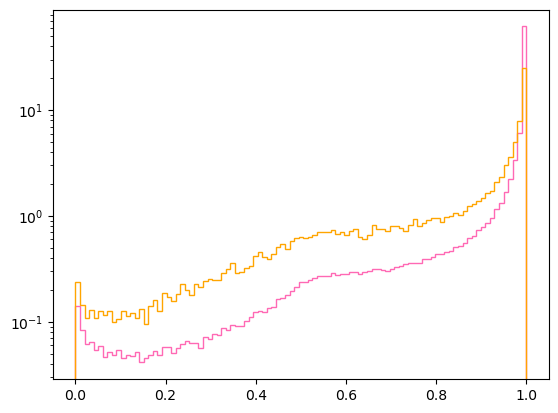

In [50]:
plt.hist(ass_proba, bins=np.linspace(0,1,100), histtype='step', color="hotpink", density="True")
plt.hist(ass_proba_mask_b, bins=np.linspace(0,1,100), histtype='step', color="orange",density="True")
plt.yscale("log")
plt.show()


### Plotting the efficiency

Now that we can recontruct H1 and H2 for which at least one of the 2 jets has a pt lower than 35, it is laso possibke to compute the efficiency

In [51]:
def preselection(dataset,label):   
    b_jet_dict={
        f"index_b1_{label}":dataset["TARGETS"]["h1"]["b1"][()],
        f"index_b2_{label}":dataset["TARGETS"]["h1"]["b2"][()],
        f"index_b3_{label}":dataset["TARGETS"]["h2"]["b3"][()],
        f"index_b4_{label}":dataset["TARGETS"]["h2"]["b4"][()],
        f"pt_{label}":dataset["INPUTS"]["Jet"]["ptPnetRegNeutrino"][()], 
    }
    return b_jet_dict

true_nc= preselection(df_true_nc, "true_new_cuts")
pred_nc= preselection(df_pred_nc_on_nc, "pred_new_cuts")

def filter_dataset(datasets, key):
    for dataset in datasets:
        if key in dataset:
            return dataset
    print("No dataset contains both keys.")
    return ""

print(true_nc[filter_dataset(preselection(df_true_nc, "true_new_cuts"), "pt")])

def mask_35_h(dataset,label):
    presel=preselection(dataset, label)
    pt= filter_dataset(presel, "pt")
    mask_pt_35=ak.any(presel[pt]<35,axis=1)
    # print(len(presel[pt][mask_pt_35]))
    idx_b1_mask= presel[filter_dataset(presel, "b1")][mask_pt_35]
    idx_b2_mask= presel[filter_dataset(presel, "b2")][mask_pt_35]
    idx_b3_mask= presel[filter_dataset(presel, "b3")][mask_pt_35]
    idx_b4_mask= presel[filter_dataset(presel, "b4")][mask_pt_35]
    
    # print(len(idx_b1_mask))
    
    row_indices=np.arange(idx_b1_mask.shape[0])
    
    pt_mask=presel[pt][mask_pt_35]
    
    mask_b1= pt_mask[row_indices,idx_b1_mask ]< 35
    mask_b2= pt_mask[row_indices,idx_b2_mask ]< 35
    mask_b3= pt_mask[row_indices,idx_b3_mask ]< 35
    mask_b4= pt_mask[row_indices,idx_b4_mask ]< 35
    
    idx_b1_35= idx_b1_mask[mask_b1 | mask_b2]
    idx_b2_35= idx_b2_mask[mask_b1 | mask_b2]
    idx_b3_35= idx_b3_mask[mask_b3 | mask_b4]
    idx_b4_35= idx_b4_mask[mask_b3 | mask_b4]
    
    # print(len(idx_b1_35))
    
    idx_h1= ak.concatenate((ak.unflatten(idx_b1_35, ak.ones_like(idx_b1_35)), ak.unflatten(idx_b2_35, ak.ones_like(idx_b2_35))), axis=1)
    idx_h2= ak.concatenate((ak.unflatten(idx_b3_35, ak.ones_like(idx_b3_35)), ak.unflatten(idx_b4_35, ak.ones_like(idx_b4_35))), axis=1)
    # idx_h= ak.concatenate((ak.unflatten(idx_h1, ak.ones_like(idx_h1)), ak.unflatten(idx_h2, ak.ones_like(idx_h2))), axis=1)
    
    return idx_h1, idx_h2 #, idx_h
    
idx_nc_pred_h1, idx_nc_pred_h2=mask_35_h(df_pred_nc, "pred_nc")
idx_nc_true_h1, idx_nc_true_h2=mask_35_h(df_true_nc, "true_nc")

idx_true_order_h1 = ak.sort(idx_nc_true_h1, axis=1)

print(idx_true_order_h1)
print(idx_nc_true_h1)
print(ak.sum(idx_nc_true_h1[:,0]>idx_nc_true_h1[:,1]))
print(ak.sum(idx_true_order_h1[:,0]>idx_true_order_h1[:,1]))

print(ak.ones_like(idx_nc_true_h1[:,0]))

print(len(idx_nc_true_h1))
print(len(idx_nc_pred_h1))

    

[[ 381.4775     56.97494    32.19304   248.06146    62.47574 ]
 [  69.26364   198.60654    57.017525   56.054173   63.21484 ]
 [ 187.8155    220.62973   115.562454   35.725597   51.955   ]
 ...
 [ 206.20268    49.492634   93.74173   130.76738  9999.      ]
 [  79.936485   61.103214  157.19423    69.72033   149.54793 ]
 [ 113.44733    86.918686  113.63911   155.72134    45.57558 ]]
[[1, 3], [1, 2], [0, 1], [0, 2], [0, ...], ..., [0, 3], [0, 2], [2, 3], [1, 2]]
[[1, 3], [1, 2], [0, 1], [0, 2], [0, ...], ..., [0, 3], [0, 2], [2, 3], [1, 2]]
2926
0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
28390
36355


In [52]:
# correctly_partially_matched_1h = (
#     ak.all(
#         idx_true_partially_matched_1h[:, 0] == idx_pred_partially_matched_1h[:, 0],
#         axis=1,
#     )
#     | ak.all(
#         idx_true_partially_matched_1h[:, 0] == idx_pred_partially_matched_1h[:, 1],
#         axis=1,
#     )
#     | ak.all(
#         idx_true_partially_matched_1h[:, 1] == idx_pred_partially_matched_1h[:, 0],
#         axis=1,
#     )
#     | ak.all(
#         idx_true_partially_matched_1h[:, 1] == idx_pred_partially_matched_1h[:, 1],
#         axis=1,
#     )
# )

Problem computing the efficiencies as the list if true and predicted H1 son't have the same lenght. To contour this problem, what we can do is to keep only the events for whoch in the predicted we actually have jets that recontruct the Higgs with pt lower than 25

In [53]:
def mask_35_h_on_pred(dataset, dataset_pred,label, label_pred):
    presel=preselection(dataset, label)
    pt= filter_dataset(presel, "pt")
    mask_pt_35=ak.any(presel[pt]<35,axis=1)
    # print(len(presel[pt][mask_pt_35]))
    idx_b1_mask= presel[filter_dataset(presel, "b1")][mask_pt_35]
    idx_b2_mask= presel[filter_dataset(presel, "b2")][mask_pt_35]
    idx_b3_mask= presel[filter_dataset(presel, "b3")][mask_pt_35]
    idx_b4_mask= presel[filter_dataset(presel, "b4")][mask_pt_35]
    
    presel_pred=preselection(dataset_pred, label_pred)
    pt_pred= filter_dataset(presel_pred, "pt")
    mask_pt_35=ak.any(presel_pred[pt_pred]<35,axis=1)
    # print(len(presel[pt][mask_pt_35]))
    idx_b1_mask_pred= presel_pred[filter_dataset(presel_pred, "b1")][mask_pt_35]
    idx_b2_mask_pred= presel_pred[filter_dataset(presel_pred, "b2")][mask_pt_35]
    idx_b3_mask_pred= presel_pred[filter_dataset(presel_pred, "b3")][mask_pt_35]
    idx_b4_mask_pred= presel_pred[filter_dataset(presel_pred, "b4")][mask_pt_35]
    
    # print(len(idx_b1_mask))
    
    row_indices=np.arange(idx_b1_mask.shape[0])
    
    pt_mask=presel_pred[pt_pred][mask_pt_35]
    
    mask_b1= pt_mask[row_indices,idx_b1_mask_pred ]< 35
    mask_b2= pt_mask[row_indices,idx_b2_mask_pred ]< 35
    mask_b3= pt_mask[row_indices,idx_b3_mask_pred ]< 35
    mask_b4= pt_mask[row_indices,idx_b4_mask_pred ]< 35
    
    idx_b1_35= idx_b1_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    idx_b2_35= idx_b2_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    idx_b3_35= idx_b3_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    idx_b4_35= idx_b4_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    
    # print(len(idx_b1_35))
    
    idx_h1= ak.concatenate((ak.unflatten(idx_b1_35, ak.ones_like(idx_b1_35)), ak.unflatten(idx_b2_35, ak.ones_like(idx_b2_35))), axis=1)
    idx_h2= ak.concatenate((ak.unflatten(idx_b3_35, ak.ones_like(idx_b3_35)), ak.unflatten(idx_b4_35, ak.ones_like(idx_b4_35))), axis=1)
    # idx_h= ak.concatenate((ak.unflatten(idx_h1, ak.ones_like(idx_h1)), ak.unflatten(idx_h2, ak.ones_like(idx_h2))), axis=1)
    
    return idx_h1, idx_h2 #, idx_h
    
idx_nc_pred_h1_pred, idx_nc_pred_h2_pred=mask_35_h_on_pred(df_pred_nc_on_nc, df_pred_nc_on_nc, "pred_nc", "pred_nc")
idx_nc_true_h1_pred, idx_nc_true_h2_pred=mask_35_h_on_pred(df_true_nc, df_pred_nc_on_nc,"true_nc", "pred_nc")

idx_true_order_h1_pred = ak.sort(idx_nc_true_h1_pred, axis=1)
idx_true_order_h2_pred = ak.sort(idx_nc_true_h2_pred, axis=1)

# print(idx_true_order_h1_pred)
# print(idx_nc_true_h1_pred)
# print(ak.sum(idx_nc_true_h1_pred[:,0]>idx_nc_true_h1_pred[:,1]))
# print(ak.sum(idx_true_order_h1_pred[:,0]>idx_true_order_h1_pred[:,1]))

# print(ak.ones_like(idx_nc_true_h1_pred[:,0]))

# print(len(idx_nc_true_h1_pred))
# print(len(idx_nc_pred_h1_pred))

# print(idx_nc_pred_h1_pred)
print(len(idx_nc_true_h1_pred))
print(len(idx_nc_true_h2_pred))

idx_h_true= ak.concatenate((ak.unflatten(idx_nc_true_h1_pred, ak.ones_like(idx_nc_true_h1_pred[:,0])), ak.unflatten(idx_nc_true_h2_pred, ak.ones_like(idx_nc_true_h2_pred[:,0]))), axis=1)
idx_h_pred= ak.concatenate((ak.unflatten(idx_nc_pred_h1_pred, ak.ones_like(idx_nc_pred_h1_pred[:,0])), ak.unflatten(idx_nc_pred_h2_pred, ak.ones_like(idx_nc_pred_h2_pred[:,0]))), axis=1)

print(idx_h_true)


# ak.all(idx_nc_pred_h1_pred==idx_nc_true_h1_pred,axis=1)
 

69211
69211
[[[0, 1], [2, 3]], [[1, 3], [0, 2]], ..., [[1, 2], ...], [[0, 2], [1, 3]]]


In [54]:

correctly_fully_matched = (
    ak.all(
        idx_h_true[:, 0] == idx_h_pred[:, 0],
        axis=1,
    )
    | ak.all(
        idx_h_true[:, 0] == idx_h_pred[:, 1],
        axis=1,
    )
    | ak.all(
        idx_h_true[:, 1] == idx_h_pred[:, 0],
        axis=1,
    )
    | ak.all(
        idx_h_true[:, 1] == idx_h_pred[:, 1],
        axis=1,
    )
)

print(ak.sum(correctly_fully_matched) / len(idx_h_true))

0.874456372541937


In [55]:
correctly_matched_h1 = (
    ak.all(
        idx_true_order_h1_pred == idx_nc_pred_h1_pred, axis=1 
    )
)

print(correctly_matched_h1)
print(ak.sum(correctly_matched_h1) / len(idx_true_order_h1_pred))

[False, False, True, False, False, False, ..., True, False, True, True, True]
0.42215832743350046


In [56]:
correctly_matched_h2 = (
    ak.all(
        idx_true_order_h2_pred == idx_nc_pred_h2_pred, axis=1 
    )
)

print(correctly_matched_h2)
print(ak.sum(correctly_matched_h2) / len(idx_true_order_h2_pred))

[False, False, True, False, False, False, ..., True, False, True, True, True]
0.4070595714554045


## All kl

In [57]:
df_pred_nc_on_nc["TARGETS"].keys()
print(df_pred_nc_on_nc["TARGETS"]["h1"].keys())
print(df_pred_nc_on_nc["TARGETS"]["h1"]["assignment_probability"][()])
print(df_pred_nc_on_nc["INPUTS"]["Jet"].keys())

<KeysViewHDF5 ['assignment_probability', 'b1', 'b2', 'detection_probability', 'marginal_probability']>
[0.99674165 0.99940735 0.4177115  ... 0.99999356 0.9954484  0.99816495]
<KeysViewHDF5 ['MASK', 'btag', 'btag_wp_bit', 'cosPhi', 'eta', 'mass', 'phi', 'pt', 'ptPnetRegNeutrino', 'sinPhi']>


In [58]:
def assigment_proba(dataset, label):
    presel=preselection(dataset, label)
    pt= filter_dataset(presel, "pt")
    mask_pt_35=ak.any(presel[pt]<35,axis=1)
    # print(len(presel[pt][mask_pt_35]))
    idx_b1_mask= presel[filter_dataset(presel, "b1")][mask_pt_35]
    idx_b2_mask= presel[filter_dataset(presel, "b2")][mask_pt_35]
    idx_b3_mask= presel[filter_dataset(presel, "b3")][mask_pt_35]
    idx_b4_mask= presel[filter_dataset(presel, "b4")][mask_pt_35]
    
    # print(len(idx_b1_mask))
    
    row_indices=np.arange(idx_b1_mask.shape[0])
    
    pt_mask=presel[pt][mask_pt_35]
    
    mask_b1= pt_mask[row_indices,idx_b1_mask ]< 35
    mask_b2= pt_mask[row_indices,idx_b2_mask ]< 35
    mask_b3= pt_mask[row_indices,idx_b3_mask ]< 35
    mask_b4= pt_mask[row_indices,idx_b4_mask ]< 35
    

    ass_proba_h1=df_pred_nc["TARGETS"]["h1"]["assignment_probability"][()]
    ass_proba_mask_h1=ass_proba_h1[mask_pt_35]
    ass_proba_h1_total_mask=ass_proba_mask_h1[mask_b1 | mask_b2]
    
    ass_proba_h2=df_pred_nc["TARGETS"]["h2"]["assignment_probability"][()]
    ass_proba_mask_h2=ass_proba_h2[mask_pt_35]
    ass_proba_h2_total_mask=ass_proba_mask_h2[mask_b3 | mask_b4]
    

    return ass_proba_h1_total_mask, ass_proba_h1, ass_proba_h2_total_mask, ass_proba_h2
    
ass_proba_mask_h1, ass_proba_h1, ass_proba_mask_h2,ass_proba_h2 =assigment_proba(df_pred_nc, "Pred") 

print(ass_proba_h1)
print(ass_proba_h2)
    
print(len(ass_proba_h1))
print(len(ass_proba_h2))
    

[0.99674165 0.99940735 0.4177115  ... 0.99999356 0.9954484  0.99816495]
[0.99986196 0.9917316  0.99990857 ... 0.9999995  0.99059445 0.99522984]
419287
419287


In [59]:
def assigment_proba_kl(dataset, label, kl):
    
    mask_kl=dataset['INPUTS']['Event']['kl'][()]==kl
    presel=preselection(dataset, label)
    pt= filter_dataset(presel, "pt")
    pt_kl=presel[pt][mask_kl]
    print("pt_kl",pt_kl)
    print(len(pt_kl))
    mask_pt_35=ak.any(pt_kl<35,axis=1)
    # # print(len(presel[pt][mask_pt_35]))
    idx_b1_mask= presel[filter_dataset(presel, "b1")][mask_kl][mask_pt_35]
    idx_b2_mask= presel[filter_dataset(presel, "b2")][mask_kl][mask_pt_35]
    idx_b3_mask= presel[filter_dataset(presel, "b3")][mask_kl][mask_pt_35]
    idx_b4_mask= presel[filter_dataset(presel, "b4")][mask_kl][mask_pt_35]
    
    # print(len(idx_b1_mask))
    
    row_indices=np.arange(idx_b1_mask.shape[0])
    
    pt_mask=pt_kl[mask_pt_35]
    
    mask_b1= pt_mask[row_indices,idx_b1_mask ]< 35
    mask_b2= pt_mask[row_indices,idx_b2_mask ]< 35
    mask_b3= pt_mask[row_indices,idx_b3_mask ]< 35
    mask_b4= pt_mask[row_indices,idx_b4_mask ]< 35
    

    ass_proba_h1=df_pred_nc["TARGETS"]["h1"]["assignment_probability"][()] 
    ass_proba_h1_kl=ass_proba_h1[mask_kl]
    print(ass_proba_h1)
    ass_proba_mask_h1=ass_proba_h1_kl[mask_pt_35]
    ass_proba_h1_total_mask=ass_proba_mask_h1[mask_b1 | mask_b2]
    
    ass_proba_h2=df_pred_nc["TARGETS"]["h2"]["assignment_probability"][()]
    ass_proba_h2_kl=ass_proba_h2[mask_kl]
    ass_proba_mask_h2=ass_proba_h2_kl[mask_pt_35]
    ass_proba_h2_total_mask=ass_proba_mask_h2[mask_b3 | mask_b4]
    

    return ass_proba_h1_kl, ass_proba_h1_total_mask,ass_proba_h2_kl, ass_proba_h2_total_mask

ass_proba_h1_kl1,ass_proba_mask_h1_kl1, ass_proba_h2_kl1, ass_proba_mask_h2_kl1=assigment_proba_kl(df_pred_nc, "Pred", 1) 
# ass_proba_h1_kl1=assigment_proba_kl(df_pred_nc, "Pred", 1) 

print(len(ass_proba_h1_kl1))
print(len(ass_proba_mask_h1_kl1))

pt_kl [[ 187.8155    220.62973   115.562454   35.725597   51.955   ]
 [  53.869442   98.3845    128.62994   104.93119   164.69527 ]
 [ 175.12326   182.77173   139.68741    84.56269    25.601376]
 ...
 [ 206.20268    49.492634   93.74173   130.76738  9999.      ]
 [  79.936485   61.103214  157.19423    69.72033   149.54793 ]
 [ 113.44733    86.918686  113.63911   155.72134    45.57558 ]]
155175
[0.99674165 0.99940735 0.4177115  ... 0.99999356 0.9954484  0.99816495]
155175
12322


In [60]:
def mask_35_h_on_pred(dataset, dataset_pred,label, label_pred,kl):
    
    mask_kl=dataset['INPUTS']['Event']['kl'][()]==kl
    presel=preselection(dataset, label)
    pt= filter_dataset(presel, "pt")
    mask_pt_35=ak.any(presel[pt]<35,axis=1)
    # print(len(presel[pt][mask_pt_35]))
    idx_b1_mask= presel[filter_dataset(presel, "b1")][mask_pt_35]
    idx_b2_mask= presel[filter_dataset(presel, "b2")][mask_pt_35]
    idx_b3_mask= presel[filter_dataset(presel, "b3")][mask_pt_35]
    idx_b4_mask= presel[filter_dataset(presel, "b4")][mask_pt_35]
    
    presel_pred=preselection(dataset_pred, label_pred)
    pt_pred= filter_dataset(presel_pred, "pt")
    mask_pt_35=ak.any(presel_pred[pt_pred]<35,axis=1)
    # print(len(presel[pt][mask_pt_35]))
    idx_b1_mask_pred= presel_pred[filter_dataset(presel_pred, "b1")][mask_pt_35]
    idx_b2_mask_pred= presel_pred[filter_dataset(presel_pred, "b2")][mask_pt_35]
    idx_b3_mask_pred= presel_pred[filter_dataset(presel_pred, "b3")][mask_pt_35]
    idx_b4_mask_pred= presel_pred[filter_dataset(presel_pred, "b4")][mask_pt_35]
    
    # print(len(idx_b1_mask))
    
    row_indices=np.arange(idx_b1_mask.shape[0])
    
    pt_mask=presel_pred[pt_pred][mask_pt_35]
    
    mask_b1= pt_mask[row_indices,idx_b1_mask_pred ]< 35
    mask_b2= pt_mask[row_indices,idx_b2_mask_pred ]< 35
    mask_b3= pt_mask[row_indices,idx_b3_mask_pred ]< 35
    mask_b4= pt_mask[row_indices,idx_b4_mask_pred ]< 35
    
    idx_b1_35= idx_b1_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    idx_b2_35= idx_b2_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    idx_b3_35= idx_b3_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    idx_b4_35= idx_b4_mask[mask_b1 | mask_b2 | mask_b3 | mask_b4]
    
    # print(len(idx_b1_35))
    
    idx_h1= ak.concatenate((ak.unflatten(idx_b1_35, ak.ones_like(idx_b1_35)), ak.unflatten(idx_b2_35, ak.ones_like(idx_b2_35))), axis=1)
    idx_h2= ak.concatenate((ak.unflatten(idx_b3_35, ak.ones_like(idx_b3_35)), ak.unflatten(idx_b4_35, ak.ones_like(idx_b4_35))), axis=1)
    # idx_h= ak.concatenate((ak.unflatten(idx_h1, ak.ones_like(idx_h1)), ak.unflatten(idx_h2, ak.ones_like(idx_h2))), axis=1)
    
    return idx_h1, idx_h2 #, idx_h